In [2]:
import xarray as xr
import math
from pyproj import CRS, Transformer
import pyproj
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import fsspec 
from dask.distributed import Client, progress
import re
from cfgrib import xarray_to_grib
import pickle
import gc

Global Parameters

In [3]:
CMP_MAX = 1000.0
BUCKET_NAME = 'noaa-nws-hafs-pds'
DROP_VARIABLES = ['q', 'w', 'wz', 'absv', 'clwmr', 'icmr', 'rwmr', 'snmr','grle', 'rare', 'dpt', 'u','v']
MW_DROP_VARIABLES = ['q', 'w', 'wz', 'absv', 'clwmr', 'icmr', 'rwmr', 'snmr','grle', 'rare', 'dpt', 'gh', 'r', 't']


In [4]:
try:
    from dask.distributed import get_client
    get_client().close()
except Exception:
    pass

client = Client()  # set up local cluster on your laptop
client

fs = fsspec.filesystem('s3', anon=True)

Project Functions

In [5]:
def frame_processing(s3_path: str):
    '''
    Docstring for frame_processing
    
    :param ds: A HAFSA model timestep
    :type ds: xr.Dataset

    Checks for frame validity:
        No land within 200km of center
        Central minimum pressure of at least 990mb
    
    If valid returns a Model Dataset consisting of:
        PBL temp, heights, rh, and radial/azimuthal winds
        700 mb temp, heights, rh, and radial/azimuthal winds
        central minimum pressure for the frame,
        maximum wind for the frame
    '''
    header_path = 'simplecache::s3://noaa-nws-hafs-pds/'

    frame_path = header_path + s3_path
    nxt_frame_path = header_path = re.sub('.f024', '.f027', frame_path)

    frame_file = fsspec.open_local(frame_path, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})
    nxt_frame_file = fsspec.open_local(nxt_frame_path, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})

    ds_atm = xr.open_dataset(frame_file,
                         drop_variables = DROP_VARIABLES, 
                         filter_by_keys={'typeOfLevel': 'isobaricInhPa',
                                         'level': 700.0},
                         engine = 'cfgrib'
                        )   
    ds_sfc = xr.open_dataset(frame_file,  
                         filter_by_keys={'typeOfLevel': 'meanSea'},
                         engine = 'cfgrib')
    
    ds_sfc_nxt_step = xr.open_dataset(nxt_frame_file, 
                         filter_by_keys={'typeOfLevel': 'meanSea'},
                         engine = 'cfgrib')
    
    ds_sfc = ds_sfc['prmsl'].compute()/100
    c_mslp = ds_sfc.min()


    if c_mslp > CMP_MAX:
        return None
    else:
        print(c_mslp.values)
        center_coords = ds_sfc.where(ds_sfc == c_mslp, drop=True).squeeze()

    
    # computing the necessary values for the follow on frame. Necessary
    # for determining storm motion

    ds_sfc_nxt_step = ds_sfc_nxt_step['prmsl'].compute()
    c_mslp_nxt_step = ds_sfc_nxt_step.min()
    center_coords_nxt_step = ds_sfc_nxt_step.where(ds_sfc_nxt_step == c_mslp_nxt_step, drop=True).squeeze()

    storm_heading = calc_heading(center_coords.latitude.values, center_coords.longitude.values, 
                                 center_coords_nxt_step.latitude.values, center_coords_nxt_step.longitude.values)

    frame = to_polar(ds_atm.compute(),
                     origin_lat= center_coords.latitude.values,
                     origin_lon= center_coords.longitude.values,
                     storm_heading = storm_heading)
    
    return_object = {
                    'radius_coords': frame.radius.values,
                    'angle_coords': frame.angle.values,
                    'gh': frame['gh'].values,
                    't': frame['t'].values,
                    'r': frame['r'].values,
                    'center_pressure': c_mslp.values,
                    'center_lat': center_coords.latitude.values,
                    'center_lon': center_coords.longitude.values,
                    'valid_time': frame.valid_time.values,
                    'heading': storm_heading
                    }
    
    return return_object
    
def calc_heading(lat1, lon1, lat2, lon2):

    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)

    d_lon = lon2_rad - lon1_rad

    y = np.sin(d_lon) * np.cos(lat2_rad)
    x = (np.cos(lat1_rad) * np.sin(lat2_rad) -
         np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(d_lon)) 
    
    initial_bearing_rad = np.arctan2(y, x)

    initial_bearing_deg = np.rad2deg(initial_bearing_rad)

    bearing = (initial_bearing_deg + 360) % 360

    return bearing 

def rotate_point_around_origin(x, y, angle):
    """
    Rotates a 2D point (x, y) around the origin (0, 0) by a given angle.

    Args:
        x (float): The x-coordinate of the point.
        y (float): The y-coordinate of the point.
        angle_radians (float): The angle of rotation in radians (counter-clockwise).

    Returns:
        tuple: A tuple (new_x, new_y) representing the rotated point.
    """
    angle = np.deg2rad(angle)
    new_x = x * math.cos(angle) - y * math.sin(angle)
    new_y = x * math.sin(angle) + y * math.cos(angle)
    return new_x, new_y

def to_polar(
        ds: xr.Dataset,
        origin_lat: float,
        origin_lon: float,
        storm_heading: float,
        R_max = 250.0, # Max range in km
        R_step = 0.5, # Range step in km
        A_step = 0.5  # Azimuth step in degrees
    ) -> xr.Dataset:
    
        R = 6378137 # radius of Earth in meters

        new_range = np.arange(0.0, R_max + R_step, R_step)
        new_azimuth = np.arange(0.0, 360.0, A_step)
        R, T = np.meshgrid(new_azimuth, new_range, indexing = 'ij')
     
        X = R * np.cos(T) * 1000 # Convert km to meters
        Y = R * np.sin(T) * 1000
        local_proj_str = f"+proj=aeqd +lat_0={origin_lat} +lon_0={origin_lon} +units=m"
        transformer = pyproj.Transformer.from_crs(local_proj_str, "EPSG:4326", always_xy=True)

        X,Y = rotate_point_around_origin(X, Y, storm_heading)
        target_lons, target_lats = transformer.transform(X, Y)
        
        # print("Target Lats: " + str(np.shape(target_lats)))
        # print("Target Lons: " + str(np.shape(target_lons)))
        # print("range: " + str(np.shape(new_range)))
        # print("azimuth: " + str(np.shape(new_azimuth)))

        # print("New Range: " + str(new_range.max()))
        # print("New Angle: " + str(new_azimuth.max()))
        ds_out = xr.Dataset(
                            coords={
                                    "latitude": (("angle", "radius"), target_lats),
                                    "longitude": (("angle", "radius"), target_lons),
                                    "radius": new_range,
                                    "angle": new_azimuth
                                        }
                            )
        regridder = xe.Regridder(ds, ds_out, 'bilinear')
        polar_out = regridder(ds)
       
        return polar_out


         


In [6]:

loaded_list = []

with open('Data/links/link_list.txt', 'r') as f:
            for line in f:
                loaded_list.append(line.strip())

In [7]:
starting_frame = 400
partial_loaded_list = loaded_list[starting_frame:]

In [8]:
all_frames = {
                    'radius_coords': [],
                    'angle_coords': [],
                    'gh': [],
                    't': [],
                    'r': [],
                    'center_pressure': [],
                    'valid_time': []

    }
# try:
frame = frame_processing(partial_loaded_list[0])
start = '0'
# except:
#     print("Issue with link {}", partial_loaded_list[0])
#     frame = None
if frame:
    all_frames['radius_coords'].append(frame['radius_coords'])
    all_frames['angle_coords'].append(frame['angle_coords'])
    all_frames['gh'].append(frame['gh'])
    all_frames['t'].append(frame['t'])
    all_frames['r'].append(frame['r'])
    all_frames['center_pressure'].append(frame['center_pressure'])
    all_frames['valid_time'].append(frame['valid_time'])
for i, frame_path in enumerate(partial_loaded_list[1:11]):
    print(i)
    try:
        frame = frame_processing(frame_path)
    except:
        print("Issue with link {}", frame_path)
        continue
    if frame:
        print(type(frame))
        
        all_frames['radius_coords'].append(frame['radius_coords'])
        all_frames['angle_coords'].append(frame['angle_coords'])
        all_frames['gh'].append(frame['gh'])
        all_frames['t'].append(frame['t'])
        all_frames['r'].append(frame['r'])
        all_frames['center_pressure'].append(frame['center_pressure'])
        all_frames['valid_time'].append(frame['valid_time'])
       
    if i%10 == 0:
        end = str(starting_frame + i)
        # with open("CompleteData/all_frames_" + str(start) + "to" + str(end) + ".pkl", "wb") as f:
        #     pickle.dump(all_frames, f)
        
        ds = xr.Dataset(
                        data_vars = {
                                     'gh': (['valid_time', 'angle', 'radius' ], all_frames['gh']),
                                     'rh': (['valid_time','angle', 'radius'], all_frames['r']),
                                     't': (['valid_time', 'angle', 'radius'], all_frames['t']),
                                    },
                        coords= {
                                 'angle': (all_frames['angle_coords'][0]), 
                                 'radius': ( all_frames['radius_coords'][0]), 
                                 'valid_times': all_frames['valid_time']
                                }
        )
        ds.to_netcdf('test.nc')
        del all_frames
        start = i + starting_frame + 1
        all_frames = {
                    'radius_coords': [],
                    'angle_coords': [],
                    'gh': [],
                    't': [],
                    'r': [],
                    'center_pressure': [],
                    'valid_time': []
                     }
    del frame
    gc.collect()    



965.955
0
946.308
<class 'dict'>
1
975.72186
<class 'dict'>
2
968.81134
<class 'dict'>
3
952.44653
<class 'dict'>
4
967.9037
<class 'dict'>
5
973.6062
<class 'dict'>
6
965.2622
<class 'dict'>
7
971.00116
<class 'dict'>
8
963.7151
<class 'dict'>
9
982.71075
<class 'dict'>


In [9]:
ds

<xarray.Dataset> Size: 9MB
Dimensions:      (valid_time: 2, angle: 720, radius: 501, valid_times: 2)
Coordinates:
  * angle        (angle) float64 6kB 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * radius       (radius) float64 4kB 0.0 0.5 1.0 1.5 ... 249.0 249.5 250.0
  * valid_times  (valid_times) datetime64[ns] 16B 2023-08-08T18:00:00 2023-08-09
Dimensions without coordinates: valid_time
Data variables:
    gh           (valid_time, angle, radius) float32 3MB 2.793e+03 ... 3.148e+03
    rh           (valid_time, angle, radius) float32 3MB 87.4 87.4 ... 63.17
    t            (valid_time, angle, radius) float32 3MB 288.1 288.1 ... 283.1

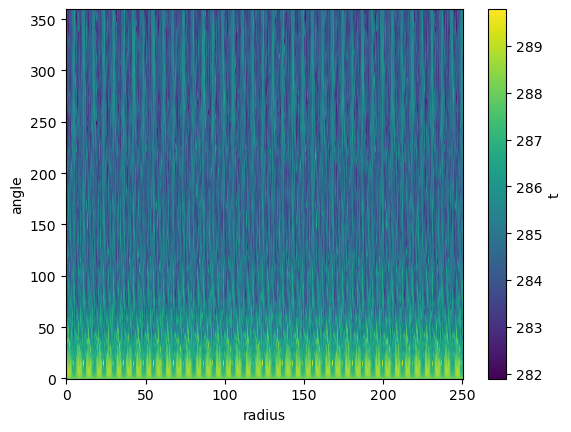

In [10]:
ds['t'].isel(valid_time = 0).plot()